### Bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

print(f'Versão Pandas: {pd.__version__}')
print(f'Versão Numpy: {np.__version__}')

Versão Pandas: 1.0.5
Versão Numpy: 1.17.4


### Bibliotecas de visualização

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use(['ggplot'])

print(f'Versão Seaborn: {sns.__version__}')
print(f'Versão Matplotlib: {matplotlib.__version__}')

Versão Seaborn: 0.10.1
Versão Matplotlib: 3.2.1


### Carregamento dos dados: MNIST

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

In [4]:
X, y = mnist['data'], mnist['target']

print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (70000, 784)
Shape y: (70000,)


### Exemplo

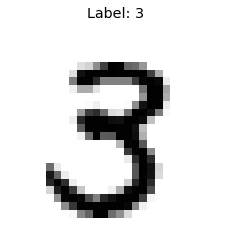

In [5]:
idx = 65356
some_digits = X[idx]
some_digits_image = some_digits.reshape(28, 28)

plt.imshow(some_digits_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.title(f'Label: {str(y[idx])}')
plt.axis('off')
plt.show()

### Mais alguns dígitos

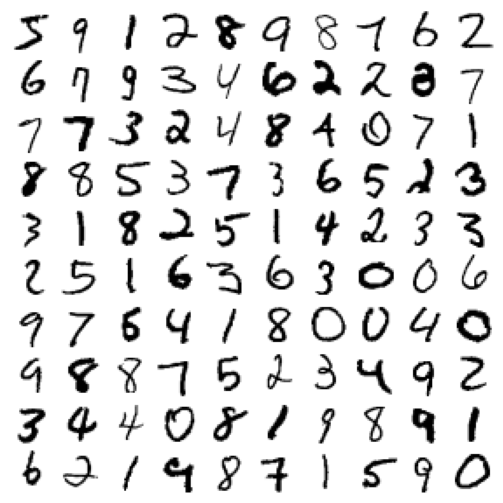

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
        
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
    
    

plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

### Separação dos dados

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape:  {X_test.shape}')
print(f'y_test shape:  {y_test.shape}')

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape:  (10000, 784)
y_test shape:  (10000,)


### Embaralhando os dados

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Treinando um classificador binário para o dígito 3

In [9]:
y_train_3 = (y_train == 3)
y_test_3  = (y_test == 3)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_3)

sgd_clf.predict([some_digits])

array([ True])

### Medidas de desempenho

#### Implementando a validação cruzada

In [11]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3, random_state=42)
scores = []

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_3[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_3[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    scores.append(n_correct/len(y_pred))
    
print(scores)   
print(f'Score: {np.mean(scores)}')

[0.94755, 0.96675, 0.9492]
Score: 0.9545


#### Validação cruzada

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([0.94755, 0.96675, 0.9492 ])

#### Gerando previsões

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

#### Matriz de confusão

In [14]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train_3, y_train_pred))

[[53605   264]
 [ 2466  3665]]


#### Precisão e recall (revocação ou sensibilidade)

In [15]:
from sklearn.metrics import precision_score, recall_score

print(f'Precisão: {precision_score(y_train_3, y_train_pred)}')
print(f'Recall: {recall_score(y_train_3, y_train_pred)}')

Precisão: 0.9328073301094426
Recall: 0.5977817648018268


#### F1-Score

In [16]:
from sklearn.metrics import f1_score

print(f'F1: {f1_score(y_train_3, y_train_pred)}')

F1: 0.7286282306163021


#### Compensação da Precisão/Recall

##### Previsões com base no limiar (threshold)

In [17]:
y_scores = sgd_clf.decision_function([some_digits])
y_scores

array([232098.45302396])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [19]:
threshold = 400000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#####  Precision recall curve

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method='decision_function')
y_scores

array([ -948505.54641036,  -126839.26946373,   103933.47069915, ...,
        -280994.77725479, -1423836.38343189,  -992780.65678651])

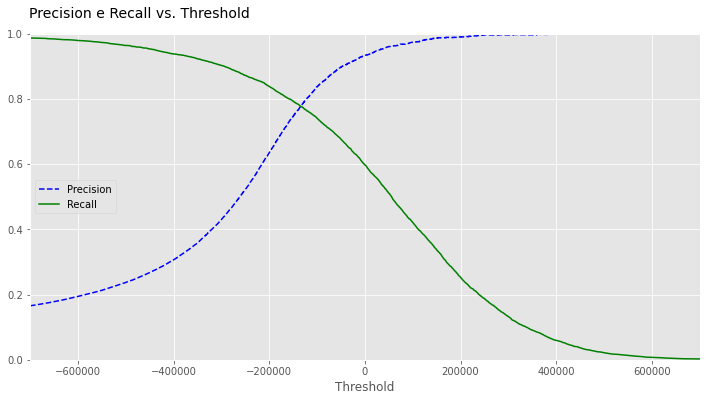

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    
plt.figure(figsize=[12, 6])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Precision e Recall vs. Threshold', y=1.03, size=14, loc='left', x=-0.002)
plt.xlim([-700000, 700000])
plt.show()

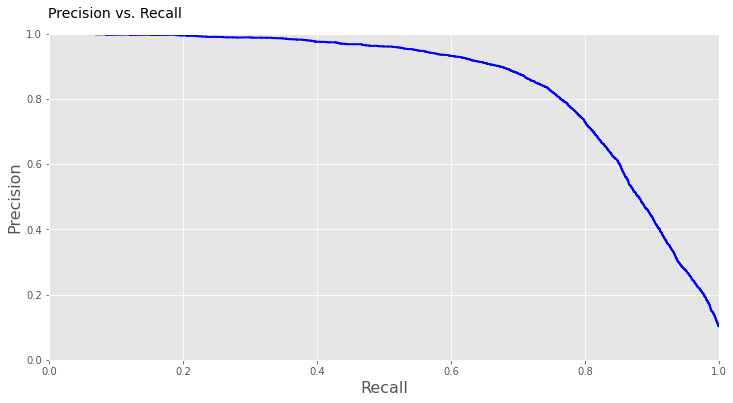

In [22]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=[12, 6])
plot_precision_vs_recall(precisions, recalls)
plt.title('Precision vs. Recall', y=1.03, size=14, loc='left', x=-0.002)
plt.show()